In [1]:
import pandas as pd


demographics_df = pd.read_csv('demographic.csv', encoding='latin1')
medications_df = pd.read_csv('medications.csv', encoding='latin1')
questionnaire_df = pd.read_csv('questionnaire.csv', encoding='latin1')

In [2]:
print(demographics_df.head())
print(medications_df.head())
print(questionnaire_df.head())

    SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  73557         8         2         1        69       NaN         4   
1  73558         8         2         1        54       NaN         3   
2  73559         8         2         1        72       NaN         3   
3  73560         8         2         1         9       NaN         3   
4  73561         8         2         2        73       NaN         3   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  DMDHREDU  DMDHRMAR  DMDHSEDU  \
0         4       1.0       NaN  ...       3.0       4.0       NaN   
1         3       1.0       NaN  ...       3.0       1.0       1.0   
2         3       2.0       NaN  ...       4.0       1.0       3.0   
3         3       1.0     119.0  ...       3.0       1.0       4.0   
4         3       1.0       NaN  ...       5.0       1.0       5.0   

       WTINT2YR      WTMEC2YR  SDMVPSU  SDMVSTRA  INDHHIN2  INDFMIN2  INDFMPIR  
0  13281.237386  13481.042095        1       112       4.0       

In [3]:

demographics_filtered = demographics_df[['SEQN', 'RIAGENDR', 'RIDAGEYR']].rename(
    columns={'RIAGENDR': 'Gender', 'RIDAGEYR': 'Age'})


medications_filtered = medications_df[['SEQN', 'RXDDRUG', 'RXDRSC1', 'RXDRSD1']]


questionnaire_filtered = questionnaire_df.filter(like="ACD").copy()
questionnaire_filtered.insert(0, 'SEQN', questionnaire_df['SEQN'])

In [4]:
merged_data = demographics_filtered.merge(
    medications_filtered, on='SEQN', how='left').merge(
    questionnaire_filtered, on='SEQN', how='left')


print(merged_data.head())

    SEQN  Gender  Age           RXDDRUG RXDRSC1  \
0  73557       1   69             99999     NaN   
1  73557       1   69           INSULIN     E11   
2  73558       1   54        GABAPENTIN  G25.81   
3  73558       1   54  INSULIN GLARGINE     E11   
4  73558       1   54        OLMESARTAN   E11.2   

                                             RXDRSD1  ACD011A  ACD011B  \
0                                                NaN      1.0      NaN   
1                           Type 2 diabetes mellitus      1.0      NaN   
2                             Restless legs syndrome      1.0      NaN   
3                           Type 2 diabetes mellitus      1.0      NaN   
4  Type 2 diabetes mellitus with kidney complicat...      1.0      NaN   

   ACD011C  ACD040  ACD110  
0      NaN     NaN     NaN  
1      NaN     NaN     NaN  
2      NaN     NaN     NaN  
3      NaN     NaN     NaN  
4      NaN     NaN     NaN  


In [5]:

def has_cardiovascular_issue(row):
    if pd.notnull(row['RXDRSD1']) and any(keyword in str(row['RXDRSD1']).lower() for keyword in ['heart', 'cardio']):
        return True
    return False


merged_data['CardiovascularIssue'] = merged_data.apply(has_cardiovascular_issue, axis=1)


print(merged_data[['SEQN', 'CardiovascularIssue']].head())

    SEQN  CardiovascularIssue
0  73557                False
1  73557                False
2  73558                False
3  73558                False
4  73558                False


In [6]:

bins = [0, 20, 30, 40, 50, 60, 70, float('inf')]
labels = ['10-20', '21-30', '31-40', '41-50', '51-60', '61-70', 'Above 70']
merged_data['AgeRange'] = pd.cut(merged_data['Age'], bins=bins, labels=labels, right=False)


age_gender_distribution = merged_data.groupby(['AgeRange', 'Gender', 'CardiovascularIssue']).size().unstack(fill_value=0)


print(age_gender_distribution)


CardiovascularIssue  False  True 
AgeRange Gender                  
10-20    1            2580      0
         2            2389      2
21-30    1             532      0
         2             609      0
31-40    1             670      2
         2             807      2
41-50    1             804     10
         2            1172     15
51-60    1            1158     28
         2            1577     29
61-70    1            1626     46
         2            1836     30
Above 70 1            1838    129
         2            2226     77


<ipython-input-6-370c23d81e84>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_gender_distribution = merged_data.groupby(['AgeRange', 'Gender', 'CardiovascularIssue']).size().unstack(fill_value=0)


In [7]:

total_population = len(merged_data)


cardio_distribution = merged_data[merged_data['CardiovascularIssue']].groupby(['AgeRange', 'Gender']).size()


print(f"Total Population: {total_population}")
print("Cardiovascular Issues by Age Range and Gender:")
print(cardio_distribution)


Total Population: 20194
Cardiovascular Issues by Age Range and Gender:
AgeRange  Gender
10-20     1           0
          2           2
21-30     1           0
          2           0
31-40     1           2
          2           2
41-50     1          10
          2          15
51-60     1          28
          2          29
61-70     1          46
          2          30
Above 70  1         129
          2          77
dtype: int64


<ipython-input-7-1617221601fb>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cardio_distribution = merged_data[merged_data['CardiovascularIssue']].groupby(['AgeRange', 'Gender']).size()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score


X = merged_data[['Age', 'Gender']].fillna(0)
y = merged_data['CardiovascularIssue'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")



Accuracy: 0.9824213914335231


In [10]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [13]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.9824213914335231


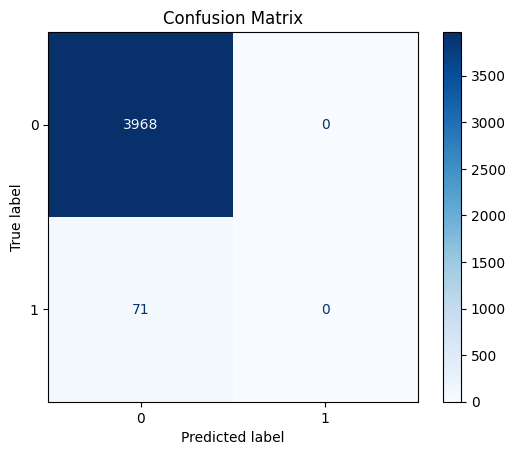

In [14]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)


plt.title("Confusion Matrix")
plt.show()